In [41]:
import random
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

import tensorflow as tf
import keras
import keras.layers as L
tf.reset_default_graph()
sess = tf.InteractiveSession()
keras.backend.set_session(sess)

plt.rcParams['figure.figsize'] = (18.0, 6.0)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [42]:
#env class based on https://gist.github.com/fheisler/430e70fa249ba30e707f

class TicTacToe(object):
    def __init__(self, size = 3, show = False):
        
        self.size = size
        self.board = [' ']*(self.size**2)
        self.winsXO = {'X':0, 'O':0}
        self.cases = self.define_end_states()
        self.coord = self.coordinates()
        self.show = show
        
    def define_players(self, playerX, playerO):
        
        self.board = [' ']*(self.size**2)
        self.playerX = playerX
        self.playerO = playerO
        self.playerX_turn = random.choice([True, False])
        
    def define_end_states(self):
        size = self.size
        cases = []

        for i in range(size):
            cases.append(list(range(size * i, size * (i + 1))))
            cases.append(list((np.array(range(size)) * size) + i))

        #Diagonals
        cases.append(list(np.array(range(size)) * (size + 1)))
        cases.append(list(np.array(range(1,size + 1)) * (size - 1)))
        
        return cases
    
    def end_game(self, char):
        size = self.size
        for end_states in self.cases:

            state_slice = [self.board[idx] for idx in end_states]
            if state_slice.count(char) == self.size:
                return True
        return False 

    def play_game(self):
        self.playerX.start_game()
        self.playerO.start_game()
        
        while True:           
            if self.playerX_turn:
                player, char, other_player = self.playerX, 'X', self.playerO
            else:
                player, char, other_player = self.playerO, 'O', self.playerX
                
            if self.show:
                print(player.name)
                print(np.array(self.board).reshape(self.size,self.size))
                
            space = player.get_action(self.board)
            
            if self.board[space] != ' ': # illegal move
                player.reward(-99, self.board)
                break
            
            self.board[space] = char
            
            if self.end_game(char): #self.player_wins(char):
                player.reward(1, self.board)
                self.winsXO[char] += 1
                other_player.reward(-1, self.board)
                break
            
            if self.board_full(): # tie game
                player.reward(0.5, self.board)
                other_player.reward(0.5, self.board)
                break
            
            other_player.reward(0, self.board) #game continues
            self.playerX_turn = not self.playerX_turn

    
    def board_full(self):
        return not any([space == ' ' for space in self.board])
    
    def legal_actions(self):
        return [i for i in range(0,(self.size**2)) if self.board[i] == ' ']
    
    def coordinates(self):
        from math import floor

        size = self.size
        board_states = list(range(size**2))
        col_index = [i % size for i in board_states]
        row_index = [floor(i/size) for i in board_states]

        return [(row_index[i], col_index[i]) for i in range(size**2)]
    
    def rotate_board(self, board, action): #rotate 3 times 90 degrees
    
        size = self.size
        board = np.array(board).reshape(size,size)

        def inv_loc(x):
            return abs(x - (self.size - 1))

        rotation_board = np.zeros((size,size))
        ref_board = board.copy()
        ref_action = self.coord[action]
        boards = []
        actions = []

        for i in range(1,4):

            # rotate board in 90 degrees
            rot_board = np.rot90(ref_board, i, (1,0))
            rot_board = list(rot_board.reshape(size**2))
            boards.append(rot_board)

            #rotate action for each 90 degrees rotation
            rot_action = (ref_action[1], inv_loc(ref_action[0]))
            actions.append(self.coord.index(rot_action))
            ref_action = rot_action

        return boards, actions


class Player(object):
    def __init__(self):
        pass
    
    def legal_actions(self, state):
        return [i for i in range(0,(self.size**2)) if state[i] == ' ']

class RandomPlayer(Player):
    def __init__(self, size):
        self.name = "Random"
        self.size = size
        self.epsilon = np.nan

    def get_action(self, state):
        return random.choice(self.legal_actions(state))
    
    def start_game(self):
        pass
    
    def reward(self, r, next_s):
        pass
    
class QLearningPlayer(Player):
    def __init__ (self, epsilon, alpha, gamma, size, use_rotation = False, rotate_board = None):
        
        self.name = "QLearning"
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.size = size
        self.use_rotation = use_rotation
        self.rotate_board = rotate_board
        
    def start_game(self):
        self.last_board = (' ',)*(self.size**2)
        self.last_move = None
        
    def reward(self, r, next_s):
        if self.last_move is not None:
            self.train_qsa(self.last_board, self.last_move, r, next_s)
            if self.use_rotation:
                last_board_rot = self.rotate_board(self.last_board, self.last_move)
                next_s_rot = self.rotate_board(next_s, 4)
                
                for i in range(len(last_board_rot)):
                    self.train_qsa(last_board_rot[0][i], last_board_rot[1][i], r, next_s_rot[0][i])
                
    def get_next_state_value(self, state):
        
        state = tuple(state)
        
        actions = self.legal_actions(state)
        A = np.zeros(len(actions))
        if len(actions) == 0:
            return 0
    
        for i,a in enumerate(actions): 
            A[i] = self._qvalues[state][a]
        return max(A)
    
    
    def train_qsa(self, state, action, reward, next_state):
               
        state = tuple(state)
        next_state = tuple(next_state)
                      
        current_qsa = self._qvalues[state][action]
        next_qsa = self.get_next_state_value(next_state)
        
        new_qsa = ((1 - self.alpha)*current_qsa) + (self.alpha * (reward + (self.gamma * next_qsa)))
        
        self._qvalues[state][action] = new_qsa

        
    def get_action(self, state):
        
        state = tuple(state)
        self.last_board = state
        
        # Lets find the best action first
        actions = self.legal_actions(state)
        if len(actions) == 0:
            return None
        
        A = np.zeros(len(actions))
        for i, a in enumerate(actions):
            
            A[i] = self._qvalues[state][a]
                 
        limit = random.uniform(0,1)
        
        if limit <= self.epsilon:
            choice_a = np.random.choice(len(actions))
            choice_a = actions[choice_a]
        else:
            if list(A).count(max(A)) > 1:
                choices = [i for i, a in enumerate(A) if a == max(A)]
                choice_a = actions[np.random.choice(choices)]
            else:
                best_a = np.argmax(A)
                choice_a = actions[best_a]
                
        self.last_move = choice_a
        return int(choice_a)
    
class DQNAgent(Player):
    
    def __init__(self, size, state_dim, action_dim, epsilon = 0, gamma = 0.9, replay = None):
        
        self.name = "DQNPlayer"
        self.replay = replay
        self.size = size
        self.epsilon = epsilon
        self.gamma = gamma
        self.state_dict = {' ':0, 'X': 1, 'O':2}
        
        #network
        self.network = keras.models.Sequential()
        self.network.add(L.InputLayer((state_dim,)))
        self.network.add(L.Dense(units=100, activation='relu'))
        self.network.add(L.Dense(units=100, activation='relu'))
        self.network.add(L.Dense(units=100, activation='relu'))
        self.network.add(L.Dense(units=100, activation='relu'))
        self.network.add(L.Dense(units=100, activation='relu'))
        self.network.add(L.Dense(units=50, activation='relu'))
        self.network.add(L.Dense(units=action_dim, activation='linear'))
                  
        #target_network
        self.target_network = keras.models.clone_model(self.network) 
        
        
        #placeholders to store data as it comes in
        self.state_ph = tf.placeholder('float32', shape=(None,) + (state_dim,))
        self.actions_ph = tf.placeholder('int32', shape=[None])
        self.rewards_ph = tf.placeholder('float32', shape=[None])
        self.next_state_ph = tf.placeholder('float32', shape=(None,) + (state_dim,))
        
        #get all qvalues of current state
        self.current_qvalues = self.network(self.state_ph)
        
        #qvalues as one hot matrix
        self.current_action_qvalues = tf.reduce_sum(tf.one_hot(self.actions_ph, action_dim) * self.current_qvalues, axis=1)
        
        # compute q-values for NEXT states. with target network
        self.next_qvalues_target = self.target_network(self.next_state_ph)

        # compute state values by taking max over next_qvalues_target for all actions
        self.next_state_values_target = tf.reduce_max(self.next_qvalues_target, axis=1)

        # compute Q_reference(s,a)
        self.reference_qvalues = self.rewards_ph + (self.gamma * self.next_state_values_target)

        # Define loss function for sgd.
        self.td_loss = (self.current_action_qvalues - self.reference_qvalues) ** 2
        self.td_loss = tf.reduce_mean(self.td_loss)

        self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.td_loss, var_list=self.network.weights)
        sess.run(tf.global_variables_initializer())
                
        
    def get_qvalues(self, state):
        
        return self.network.predict(state[None])
    
    def state_transform(self, state):
        
        return [self.state_dict[s] for s in state]
    
    def start_game(self):
        self.last_board = np.array(self.state_transform((' ',)*(self.size**2)))
        self.last_move = None
        
    def get_action(self, state):
        
        actions = self.legal_actions(state)
        if len(actions) == 0:
            return None
        
        state = np.array(self.state_transform(state))
        self.last_board = state
        limit = random.uniform(0,1)
        
        qvalues = self.get_qvalues(state)[0]
        
        A = np.zeros(len(actions))
        for i, a in enumerate(actions):
            A[i] = qvalues[a]
                
        limit = random.uniform(0,1)
        
        if limit <= self.epsilon:
            choice_a = np.random.choice(len(actions))
            choice_a = actions[choice_a]
        else:
            if list(A).count(max(A)) > 1:
                choices = [i for i, a in enumerate(A) if a == max(A)]
                choice_a = actions[np.random.choice(choices)]
            else:
                best_a = np.argmax(A)
                choice_a = actions[best_a]
                
        self.last_move = choice_a
        return int(choice_a)
        
    def reward(self, r, next_s):
        
        if self.last_move is not None:
            next_s = np.array(self.state_transform(next_s))
                                           
            sess.run(self.train_step,{
                    self.state_ph: [self.last_board], self.actions_ph: [self.last_move], self.rewards_ph: [r], 
                    self.next_state_ph: [next_s]
                })
            
            if self.replay:
                self.replay.add(self.last_board, self.last_move, next_s, r)
                replay_values = self.replay.sample(32)
                state_r, action_r, next_state_r, reward_r = replay_values
                    
                sess.run(self.train_step,{
                    self.state_ph: state_r, self.actions_ph: action_r, self.rewards_ph: reward_r, 
                    self.next_state_ph: next_state_r
                })
                
class DPGAgent(Player):
    
    def __init__(self):
        self.name = 'DPGPlayer'
        

class ExperienceReplay(object):
    
    def __init__(self, replay_size):
        
        self.replay_size = replay_size
        self._storage = []
        
    def add(self, state, action, next_state, reward):
        
        tuple_values = (state, action, next_state, reward)
        
        if len(self._storage) == self.replay_size:
            random_value = np.random.choice(len(self._storage))
            self._storage.pop(random_value)
            self._storage.append(tuple_values)
        else:
            self._storage.append(tuple_values)
                
    def sample(self, batch_size):
        
        ids = np.random.choice(len(self._storage), batch_size)
        replay = np.array(self._storage)[ids]
        
        states_replay = []
        action_replay = []
        next_states_replay = []
        reward_replay = []
        
        for i in range(batch_size):
            
            states_i = replay[i][0]
            action_i = replay[i][1]
            next_states_i = replay[i][2]
            reward_i = replay[i][3]
            
            states_replay.append(states_i)
            action_replay.append(action_i)
            next_states_replay.append(next_states_i)
            reward_replay.append(reward_i)
            
        return states_replay, action_replay, next_states_replay, reward_replay

In [49]:
def train_and_plot(env, games_vs_random, eps_decrease, p1, p2, p_random, interactions, results_train, results_test, up_weights_int = None):
    
    
    #p1: Player that we want to train on X
    #p2: Player that we want to train on O
    #p_random: Player that we want to play as long as training goes
    
    if up_weights_int:
        if interactions % up_weights_int == 0:
            try:
                p1.target_network.set_weights(p1.network.get_weights())
                p1.target_network.set_weights(p2.network.get_weights())
            except:
                pass
                 
    # epsilon decrease, test and plot
    if interactions % 1000 == 0:
        p1.epsilon *= eps_decrease
        p2.epsilon *= eps_decrease
        env_test = TicTacToe(size = env.size)

        for i in range(games_vs_random):
            env_test.define_players(p1, p_random)
            env_test.play_game()

        #plot p1 results
        clear_output(True)
        results_test.append(env_test.winsXO['X'])
        results_train.append(env.winsXO['X'])
        
        env.winsXO['X'] = 0
        env.winsXO['O'] = 0
                       
        plt.subplot(1, 2, 2)
        plt.plot(results_test, label = p1.name + ' vs ' + p2.name + '\n' + 
                 'Agent epsilon: %.3f | Opponent epsilon: %.3f' %(p1.epsilon, p2.epsilon))
        plt.title('Tests results ' + str(env.size) + ' x ' + str(env.size))
        plt.legend(bbox_to_anchor=(0,1.06,1,0.2), loc="lower left")
        
        plt.subplot(1, 2, 1)
        plt.plot(results_train, label =  p1.name + ' vs ' + p2.name + '\n' + 
                 'Agent epsilon: %.3f | Opponent epsilon: %.3f' %(p1.epsilon, p2.epsilon))
        plt.title('Training results ' + str(env.size) + ' x ' + str(env.size))
        plt.legend(bbox_to_anchor=(0,1.06,1,0.2), loc="lower left")
  
        
    #p1 and p2 training
    env.define_players(p1, p2)
    env.play_game()
    #print(env.winsXO, interactions)
           
    return results_train, results_test


def test_agent(env, pX, pO, games = 500):
    
    pX.epsilon = 0
    pO.epsilon = 0
    for i in range(games):
        env.define_players(pX, pO)
        env.play_game()
    return env.winsXO

In [44]:
#Size 3 x 3
np.random.seed(2)

#Env definition
env = TicTacToe(size = 3)
env_test = TicTacToe(size = env.size)
rep = ExperienceReplay(10000)

#Parameters
epsilon = 0.3
games_vs_random = 100
episodes = 500000
alpha = 0.5
gamma = 0.9
eps_decrease = 0.99
   
#Players Definition
#Random player
pr = RandomPlayer(size = env.size)

#Qlearning players
pQ1 = QLearningPlayer(epsilon = epsilon, alpha = alpha, gamma = gamma, size = env.size, use_rotation = False, rotate_board = env.rotate_board)
pQ2 = QLearningPlayer(epsilon = epsilon, alpha = alpha, gamma = gamma, size = env.size, use_rotation = False, rotate_board = env.rotate_board)

#DQN Players
pDQN1 = DQNAgent(epsilon = 1, gamma = 0.9, size = env.size,state_dim = env.size ** 2, action_dim = env.size ** 2, replay = None)
pDQN2 = DQNAgent(epsilon = 1, gamma = 0.9, size = env.size,state_dim = env.size ** 2, action_dim = env.size ** 2, replay = None)
pDQN3 = DQNAgent(epsilon = 1, gamma = 0.9, size = env.size,state_dim = env.size ** 2, action_dim = env.size ** 2, replay = None)

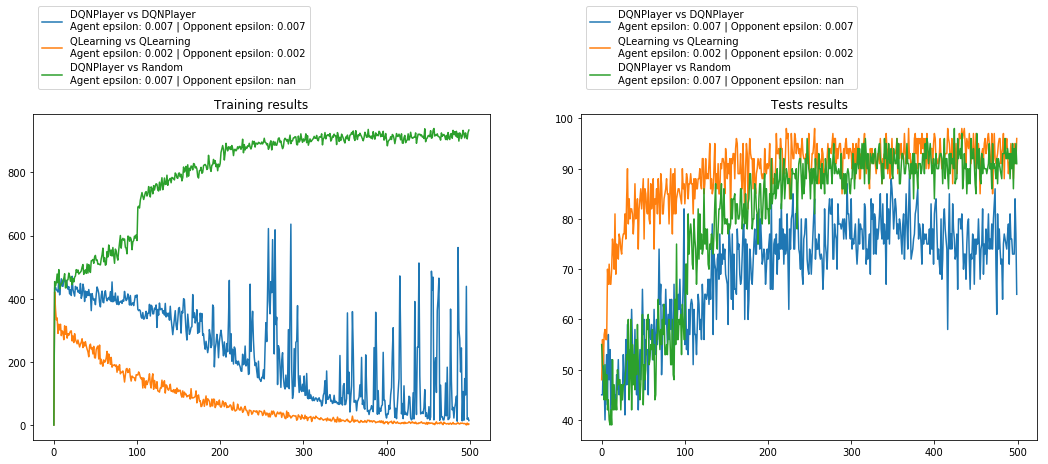

In [45]:
fig = plt.figure()
results_p1_train, results_p1_test  = [], []
results_p2_train, results_p2_test  = [], []
results_p3_train, results_p3_test  = [], []
env_1 = TicTacToe(size = env.size)
env_2 = TicTacToe(size = env.size)
env_3 = TicTacToe(size = env.size)


for i in range(episodes):
    
    results_p1_train, results_p1_test  = train_and_plot(env_1
                                                        ,games_vs_random
                                                        ,eps_decrease
                                                        ,pDQN1
                                                        ,pDQN2
                                                        ,pr
                                                        ,i
                                                        ,results_p1_train
                                                        ,results_p1_test
                                                        ,episodes / 5)
    
    results_p2_train, results_p2_test  = train_and_plot(env_2
                                                        ,games_vs_random
                                                        ,eps_decrease
                                                        ,pQ1
                                                        ,pQ2
                                                        ,pr
                                                        ,i
                                                        ,results_p2_train
                                                        ,results_p2_test
                                                        ,episodes / 5)
    
    results_p3_train, results_p3_test  = train_and_plot(env_3
                                                        ,games_vs_random
                                                        ,eps_decrease
                                                        ,pDQN3
                                                        ,pr
                                                        ,pr
                                                        ,i
                                                        ,results_p3_train
                                                        ,results_p3_test
                                                        ,episodes / 5)
        
    plt.show()
    

In [53]:
np.random.seed(2)

#Env definition
env = TicTacToe(size = 4)
env_test = TicTacToe(size = env.size)
rep = ExperienceReplay(10000)

#Parameters
epsilon = 0.8
games_vs_random = 100
episodes = 700000
alpha = 0.5
gamma = 0.9
eps_decrease = 0.995
  
#Players Definition
#Random player
pr = RandomPlayer(size = env.size)

#Qlearning players
pQ1 = QLearningPlayer(epsilon = epsilon, alpha = alpha, gamma = gamma, size = env.size, use_rotation = False, rotate_board = env.rotate_board)
pQ2 = QLearningPlayer(epsilon = epsilon, alpha = alpha, gamma = gamma, size = env.size, use_rotation = False, rotate_board = env.rotate_board)
pQR1 = QLearningPlayer(epsilon = epsilon, alpha = alpha, gamma = gamma, size = env.size, use_rotation = True, rotate_board = env.rotate_board)

#DQN Players
pDQN1 = DQNAgent(epsilon = 1, gamma = 0.9, size = env.size,state_dim = env.size ** 2, action_dim = env.size ** 2, replay = None)
pDQN2 = DQNAgent(epsilon = 1, gamma = 0.9, size = env.size,state_dim = env.size ** 2, action_dim = env.size ** 2, replay = None)
pDQN3 = DQNAgent(epsilon = 1, gamma = 0.9, size = env.size,state_dim = env.size ** 2, action_dim = env.size ** 2, replay = None)
pDQNr1 = DQNAgent(epsilon = 1, gamma = 0.9, size = env.size,state_dim = env.size ** 2, action_dim = env.size ** 2, replay = rep)

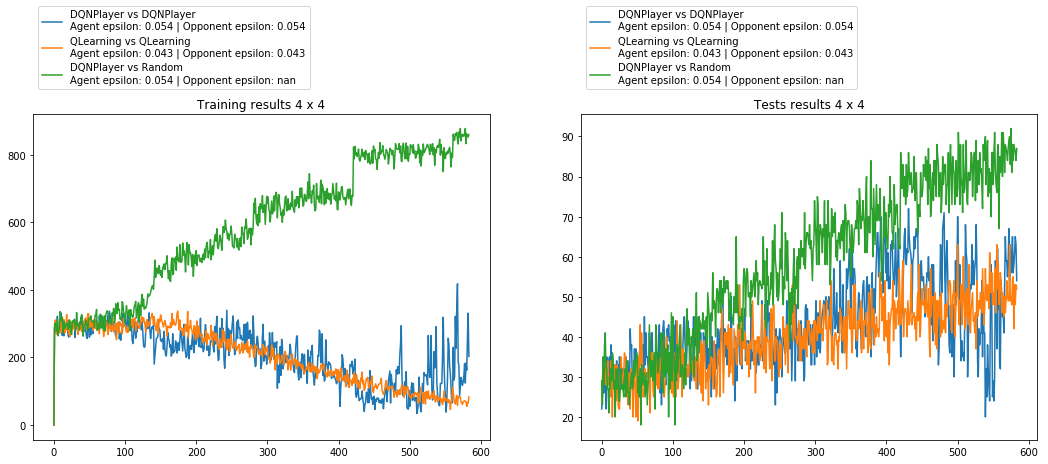

KeyboardInterrupt: 

In [54]:
fig = plt.figure()
results_p1_train, results_p1_test  = [], []
results_p2_train, results_p2_test  = [], []
results_p3_train, results_p3_test  = [], []
env_1 = TicTacToe(size = env.size)
env_2 = TicTacToe(size = env.size)
env_3 = TicTacToe(size = env.size)

for i in range(episodes):
    
    results_p1_train, results_p1_test  = train_and_plot(env_1
                                                        ,games_vs_random
                                                        ,eps_decrease
                                                        ,pDQN1
                                                        ,pDQN2
                                                        ,pr
                                                        ,i
                                                        ,results_p1_train
                                                        ,results_p1_test
                                                        ,episodes / 5)
    
    results_p2_train, results_p2_test  = train_and_plot(env_2
                                                        ,games_vs_random
                                                        ,eps_decrease
                                                        ,pQ1
                                                        ,pQ2
                                                        ,pr
                                                        ,i
                                                        ,results_p2_train
                                                        ,results_p2_test
                                                        ,episodes / 5)
    
    results_p3_train, results_p3_test  = train_and_plot(env_3
                                                        ,games_vs_random
                                                        ,eps_decrease
                                                        ,pDQN3
                                                        ,pr
                                                        ,pr
                                                        ,i
                                                        ,results_p3_train
                                                        ,results_p3_test
                                                        ,episodes / 5)
        
    plt.show()
    

In [25]:
env_test = TicTacToe(size = env.size)
test_agent(env_test, pQ1, pr, games = 500)

{'O': 0, 'X': 481}